In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import wandb
from keras.datasets import fashion_mnist
from PIL import Image

## Question-01

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yeshu183 (yeshu183-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


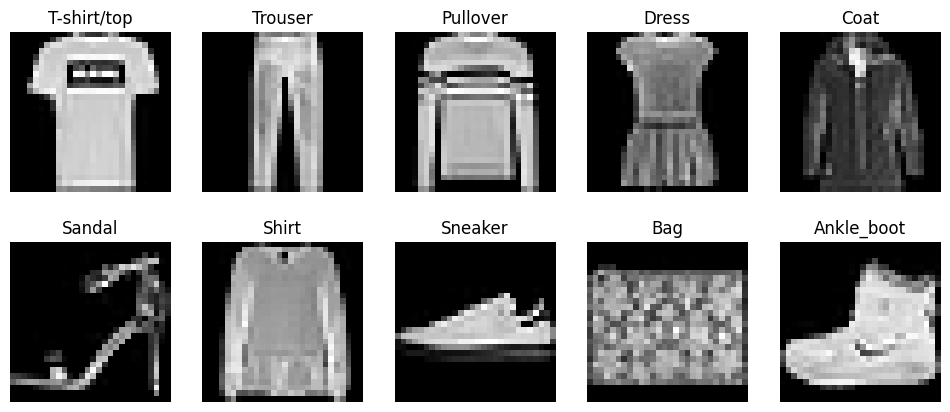

In [3]:
# Initialize wandb
wandb.init(project="fashion-mnist-classes")

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Class labels in Fashion-MNIST
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle_boot"
]
plt.figure(figsize=[12, 5])

# Select one image per class
sample_images = {}
st = set()
for x,y in zip(x_train,y_train):
    if y in st:
      continue
    else:
      st.add(y)
      sample_images[class_labels[y]] = wandb.Image(x)
      plt.subplot(2, 5, y+1)
      plt.imshow(x, cmap='gray')
      plt.axis('off')
      plt.title(class_labels[y])

# Log images to wandb
wandb.log({"fashion-mnist-classes": [wandb.Image(img,caption=caption) for caption,img in sample_images.items()]})

# Finish wandb run API Key: f659082c2b19bf3ffaaceceb36c1e280541f6b11
wandb.finish()

##Question-02

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# Split validation set (10% of training data)
val_size = int(0.1 * len(x_train))
x_val, y_val = x_train[:val_size], y_train[:val_size]
x_train, y_train = x_train[val_size:], y_train[val_size:]

# Normalize inputs
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_val = x_val.reshape(x_val.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

# One-hot encoding of labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

In [5]:
wandb.finish()

In [4]:
class Optimizers:
    def __init__(self, lr=1e-3, epsilon=1e-8):
        self.lr = lr
        self.epsilon = epsilon  # Small value to prevent division by zero

        # Initialize state dictionaries
        self.v = {}  # Velocity (for momentum, NAG)
        self.s = {}  # Squared gradients (for RMSprop, Adam, Nadam)
        self.m = {}  # First moment (for Adam/Nadam)
        self.t = 0   # Time step (for Adam/Nadam)

    def _initialize_params(self, w_key, param_shape):
        """Initialize optimizer states for a given parameter key"""
        if w_key not in self.v:
            self.v[w_key] = np.zeros(param_shape)
            self.s[w_key] = np.zeros(param_shape)
            self.m[w_key] = np.zeros(param_shape)

    def sgd(self, w, b, dw, db, key="w"):
        """Vanilla Stochastic Gradient Descent"""
        w -= self.lr * dw
        b -= self.lr * db
        return w, b

    def momentum(self, w, b, dw, db, key="w", beta1=0.9):
        """Momentum-based Gradient Descent"""
        self._initialize_params(key, w.shape)
        self.v[key] = beta1 * self.v[key] - self.lr * dw
        w += self.v[key]
        b -= self.lr * db
        return w, b

    def nesterov(self, w, b, dw, db, key="w", beta1=0.9):
        """Nesterov Accelerated Gradient (NAG)"""
        self._initialize_params(key, w.shape)
        prev_v = self.v[key]
        self.v[key] = beta1 * self.v[key] - self.lr * dw
        w += -beta1 * prev_v + (1 + beta1) * self.v[key]
        b -= self.lr * db
        return w, b

    def rmsprop(self, w, b, dw, db, key="w", rho=0.9):
        """RMSprop Optimization"""
        self._initialize_params(key, w.shape)
        self.s[key] = rho * self.s[key] + (1 - rho) * (dw ** 2)
        w -= self.lr * dw / (np.sqrt(self.s[key]) + self.epsilon)
        b -= self.lr * db
        return w, b

    def adam(self, w, b, dw, db, key="w", beta1=0.9, beta2=0.999):
        """Adaptive Moment Estimation (Adam)"""
        self._initialize_params(key, w.shape)
        self.t += 1  # Time step
        self.m[key] = beta1 * self.m[key] + (1 - beta1) * dw
        self.s[key] = beta2 * self.s[key] + (1 - beta2) * (dw ** 2)

        m_hat = self.m[key] / (1 - beta1 ** self.t)
        s_hat = self.s[key] / (1 - beta2 ** self.t)

        w -= self.lr * m_hat / (np.sqrt(s_hat) + self.epsilon)
        b -= self.lr * db
        return w, b

    def nadam(self, w, b, dw, db, key="w", beta1=0.9, beta2=0.999):
        """Nadam Optimization (Adam + Nesterov)"""
        self._initialize_params(key, w.shape)
        self.t += 1  # Time step
        self.m[key] = beta1 * self.m[key] + (1 - beta1) * dw
        self.s[key] = beta2 * self.s[key] + (1 - beta2) * (dw ** 2)

        m_hat = self.m[key] / (1 - beta1 ** self.t)
        s_hat = self.s[key] / (1 - beta2 ** self.t)

        m_nesterov = beta1 * m_hat + (1 - beta1) * dw / (1 - beta1 ** self.t)

        w -= self.lr * m_nesterov / (np.sqrt(s_hat) + self.epsilon)
        b -= self.lr * db
        return w, b


In [5]:
# Define activation functions class
class ActivationFunctions:
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def tanh(z):
        return np.tanh(z)

    def relu(z):
        return np.maximum(0, z)

    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [10]:
from os import access
# Initialize Weights & Biases (wandb)
wandb.finish()
wandb.init(project="Neural Network class")



# Define weight initialization methods
def random_init(shape):
    return np.random.randn(*shape) * 0.01

def xavier_init(shape):
    return np.random.randn(*shape) * np.sqrt(1 / shape[0])

# Define gradient descent algorithms class
# class Optimizers:
#     def __init__(self, lr=1e-3):
#         self.lr = lr

#     def sgd(self, w, b, dw, db):
#         w -= self.lr * dw
#         b -= self.lr * db
#         return w, b
# Define the neural network class
class NeuralNetwork:
    def __init__(self, input_size,num_hid_layers, hid_layer_size, output_size=10, activation='relu', weight_init='random', l2_reg=0.0, optimizer='sgd', lr=1e-3):
        self.layers = [input_size] + num_hid_layers*[hid_layer_size] + [output_size]
        self.activation_func = getattr(ActivationFunctions, activation)
        self.weight_init = {'random': random_init, 'xavier': xavier_init}[weight_init]
        self.l2_reg = l2_reg
        self.optimizer = Optimizers(lr)  # Create an instance of Optimizers
        self.optimizer_function = getattr(self.optimizer, optimizer)
        self.weights = [self.weight_init((self.layers[i], self.layers[i+1])) for i in range(len(self.layers) - 1)]
        self.biases = [self.weight_init((1, self.layers[i+1])) for i in range(len(self.layers) - 1)]

    def forward(self, x):
        activations = [x]
        z_values = []
        for i in range(len(self.weights) - 1):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            x = self.activation_func(z)
            z_values.append(z)
            activations.append(x)
        z = np.dot(x, self.weights[-1]) + self.biases[-1]
        x = ActivationFunctions.softmax(z)
        z_values.append(z)
        activations.append(x)
        return activations, z_values

    def compute_loss(self, y_pred, y_true):
        l2_penalty = self.l2_reg * sum(np.sum(w**2) for w in self.weights) / 2
        return -np.mean(y_true * np.log(y_pred + 1e-9)) + l2_penalty

    def compute_accuracy(self, y_pred, y_true):
        # Convert one-hot encoded true labels to class indices
        y_true_labels = np.argmax(y_true, axis=1)
        # Convert predicted probabilities to class indices
        y_pred_labels = np.argmax(y_pred, axis=1)
        # Compute accuracy
        accuracy = np.mean(y_pred_labels == y_true_labels)
        return accuracy


    def backward(self, activations, z_values, y_true):
        """
        Perform backpropagation with different activation functions.

        Parameters:
        - activations: List of activations from each layer.
        - z_values: List of pre-activation values (Z) from each layer.
        - y_true: True labels.
        - activation_funcs: List of activation functions used in each layer.

        Returns:
        - grad_weights: Gradients for weights.
        - grad_biases: Gradients for biases.
        """
        grad_weights = [None] * len(self.weights)
        grad_biases = [None] * len(self.biases)

        # Derivative functions for activation functions
        def relu_derivative(z):
            return (z > 0).astype(float)

        def tanh_derivative(z):
            return 1 - np.tanh(z) ** 2

        def sigmoid_derivative(z):
            sig = 1 / (1 + np.exp(-z))
            return sig * (1 - sig)

        def softmax_derivative(a):
            return a * (1 - a)  # Not directly used in CE loss

        # Output layer gradient
        dz = activations[-1] - y_true  # Cross-entropy with softmax simplifies to this

        grad_weights[-1] = np.dot(activations[-2].T, dz) / len(y_true)
        grad_biases[-1] = np.sum(dz, axis=0, keepdims=True) / len(y_true)

        # Backpropagation through hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            if activation == "relu":
                dz = np.dot(dz, self.weights[i + 1].T) * relu_derivative(z_values[i])
            elif activation == "tanh":
                dz = np.dot(dz, self.weights[i + 1].T) * tanh_derivative(z_values[i])
            elif activation == "sigmoid":
                dz = np.dot(dz, self.weights[i + 1].T) * sigmoid_derivative(z_values[i])
            else:
                raise ValueError(f"Unsupported activation function: {activation}")

            grad_weights[i] = np.dot(activations[i].T, dz) / len(y_true) + self.l2_reg * self.weights[i]
            grad_biases[i] = np.sum(dz, axis=0, keepdims=True) / len(y_true)

        return grad_weights, grad_biases


    def update_parameters(self, grad_weights, grad_biases):
        for i in range(len(self.weights)):
            if self.optimizer.__class__.__name__ == "sgd":
                self.weights[i], self.biases[i] = self.optimizer_function(
                    self.weights[i], self.biases[i], grad_weights[i], grad_biases[i])
            else:
                self.weights[i], self.biases[i] = self.optimizer_function(
                    self.weights[i], self.biases[i], grad_weights[i], grad_biases[i],
                    key=f"layer_{i}")


    def train(self, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
        train_history = []
        val_history = []

        for epoch in range(epochs):
            # Shuffle training data
            indices = np.arange(len(x_train))
            np.random.shuffle(indices)

            # Training phase - process in batches
            epoch_losses = []
            epoch_predictions = []
            epoch_true_labels = []

            for i in range(0, len(x_train), batch_size):
                batch_indices = indices[i:i+batch_size]
                x_batch, y_batch = x_train[batch_indices], y_train[batch_indices]

                # Forward pass
                activations, z_values = self.forward(x_batch)

                # Store batch results for epoch-level metrics
                batch_loss = self.compute_loss(activations[-1], y_batch)
                epoch_losses.append(batch_loss * len(x_batch))  # Weighted by batch size
                epoch_predictions.append(activations[-1])
                epoch_true_labels.append(y_batch)

                # Backward pass and weight updates
                grad_weights, grad_biases = self.backward(activations, z_values, y_batch)
                self.update_parameters(grad_weights, grad_biases)

            # Compute epoch-level training metrics
            train_loss = sum(epoch_losses) / len(x_train)

            # Concatenate all batches for accuracy calculation
            all_predictions = np.vstack(epoch_predictions)
            all_true_labels = np.vstack(epoch_true_labels)
            train_accuracy = self.compute_accuracy(all_predictions, all_true_labels)

            # Validation phase - process in one go or in batches if dataset is large
            val_activations, _ = self.forward(x_val)
            val_loss = self.compute_loss(val_activations[-1], y_val)
            val_accuracy = self.compute_accuracy(val_activations[-1], y_val)

            # Log metrics
            wandb.log({
                "loss": train_loss,
                "accuracy": train_accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy,
                "epoch": epoch+1
            })

            # Store history
            train_history.append((train_loss, train_accuracy))
            val_history.append((val_loss, val_accuracy))

            # Print progress
            print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        return train_history, val_history

# Hyperparameters
num_hid_layers = 3
hid_layer_size = 64  # Changeable number of layers
weight_init = 'xavier'  # Options: 'random', 'xavier'
activation = 'relu'  # Options: 'sigmoid', 'tanh', 'relu'
l2_reg = 0.0005  # L2 regularization strength
learning_rate = 1e-3  # Options: 1e-3, 1e-4
batch_size = 32  # Options: 16, 32, 64
epochs = 5  # Options: 5, 10
optimizer = 'sgd'  # Options: 'sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam'

# Initialize and train the model
nn = NeuralNetwork(input_size=784, num_hid_layers=num_hid_layers, hid_layer_size=hid_layer_size, activation=activation, weight_init=weight_init, l2_reg=l2_reg, optimizer=optimizer, lr=learning_rate)
nn.train(x_train, y_train, x_val, y_val, epochs=epochs, batch_size=batch_size)

wandb.finish()


Epoch 1, Loss: 0.2497, Accuracy: 0.3898, Val Loss: 0.1993, Val Accuracy: 0.6027
Epoch 2, Loss: 0.1693, Accuracy: 0.6469, Val Loss: 0.1486, Val Accuracy: 0.6822
Epoch 3, Loss: 0.1406, Accuracy: 0.7016, Val Loss: 0.1326, Val Accuracy: 0.7240
Epoch 4, Loss: 0.1292, Accuracy: 0.7301, Val Loss: 0.1249, Val Accuracy: 0.7440
Epoch 5, Loss: 0.1232, Accuracy: 0.7459, Val Loss: 0.1205, Val Accuracy: 0.7622


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▃▂▁▁
accuracy,0.74594
epoch,5
loss,0.12321
val_accuracy,0.76217
val_loss,0.12055


##Question-4

In [12]:
# Initialize Weights & Biases (wandb)
wandb.finish()


# Define sweep configuration
sweep_config = {
    'method': 'bayes',  # Options: grid, random, bayes
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5,10]},
        'num_hid_layers': {'values': [3, 4, 5]},
        'hid_layer_size': {'values': [32,64,128]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']},
        'l2_reg': {'values': [0, 0.0005, 0.005]},
        'learning_rate': {'values': [1e-2, 1e-3, 1e-4]},
        'batch_size': {'values': [16, 32, 64]},
        'optimizer': {'values': ['sgd','momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="Sweep Functionality")

def train_sweep():
    wandb.init(project="Sweep Functionality")
    config = wandb.config
    wandb.run.name = f"e_{config.epochs}_hl_{config.num_hid_layers}_opt_{config.optimizer}_bs_{config.batch_size}_init_{config.weight_init}_ac_{config.activation}"

    nn = NeuralNetwork(
        input_size=784,
        num_hid_layers=config.num_hid_layers,
        hid_layer_size=config.hid_layer_size,
        activation=config.activation,
        weight_init=config.weight_init,
        l2_reg=config.l2_reg,
        optimizer=config.optimizer,
        lr=config.learning_rate
    )

    nn.train(x_train, y_train, x_val, y_val, epochs=config.epochs, batch_size=config.batch_size)

    val_activations,val_z = nn.forward(x_val)
    val_loss = nn.compute_loss(val_activations[-1], y_val)
    val_acc = nn.compute_accuracy(val_activations[-1], y_val)
    wandb.log({"val_acc": val_acc})
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

wandb.agent(sweep_id, function=train_sweep,count=20)
wandb.finish()

Create sweep with ID: 1875zz1k
Sweep URL: https://wandb.ai/yeshu183-indian-institute-of-technology-madras/Sweep%20Functionality/sweeps/1875zz1k


/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py:2296: UserWarning: Run (bxukfgav) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_run.py:2302: UserWarning: Run (bxukfgav) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
wandb: Agent Starting Run: k15y6an9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_init: random


Epoch 1, Loss: 0.0976, Accuracy: 0.5909, Val Loss: 0.0857, Val Accuracy: 0.6648
Epoch 2, Loss: 0.0767, Accuracy: 0.7000, Val Loss: 0.0713, Val Accuracy: 0.7368
Epoch 3, Loss: 0.0689, Accuracy: 0.7365, Val Loss: 0.0649, Val Accuracy: 0.7478
Epoch 4, Loss: 0.0610, Accuracy: 0.7699, Val Loss: 0.0591, Val Accuracy: 0.7833
Epoch 5, Loss: 0.0530, Accuracy: 0.8129, Val Loss: 0.0498, Val Accuracy: 0.8305
Validation Loss: 0.0498, Validation Accuracy: 0.8305


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_acc,▁
val_accuracy,▁▄▅▆█
val_loss,█▅▄▃▁▁
accuracy,0.81294
epoch,5
loss,0.05302
val_acc,0.8305
val_accuracy,0.8305


wandb: Agent Starting Run: baugkagd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier


Epoch 1, Loss: 3.5808, Accuracy: 0.2320, Val Loss: 5.4751, Val Accuracy: 0.2093
Epoch 2, Loss: 7.1380, Accuracy: 0.2066, Val Loss: 9.5092, Val Accuracy: 0.2008
Epoch 3, Loss: 13.1844, Accuracy: 0.2498, Val Loss: 17.7496, Val Accuracy: 0.3547
Epoch 4, Loss: 21.6425, Accuracy: 0.3136, Val Loss: 25.5264, Val Accuracy: 0.3297
Epoch 5, Loss: 29.6786, Accuracy: 0.3195, Val Loss: 33.1592, Val Accuracy: 0.3457
Validation Loss: 33.1592, Validation Accuracy: 0.3457


accuracy,▃▁▄██
epoch,▁▃▅▆█
loss,▁▂▄▆█
val_acc,▁
val_accuracy,▁▁█▇█
val_loss,▁▂▄▆██
accuracy,0.31946
epoch,5
loss,29.67861
val_acc,0.34567
val_accuracy,0.34567


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4r62nbbf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_init: random


Epoch 1, Loss: 0.2303, Accuracy: 0.0971, Val Loss: 0.2303, Val Accuracy: 0.0990
Epoch 2, Loss: 0.2303, Accuracy: 0.0998, Val Loss: 0.2303, Val Accuracy: 0.0983
Epoch 3, Loss: 0.2303, Accuracy: 0.0966, Val Loss: 0.2302, Val Accuracy: 0.1013
Epoch 4, Loss: 0.2303, Accuracy: 0.0988, Val Loss: 0.2303, Val Accuracy: 0.0990
Epoch 5, Loss: 0.2303, Accuracy: 0.0969, Val Loss: 0.2303, Val Accuracy: 0.0983
Epoch 6, Loss: 0.2303, Accuracy: 0.0998, Val Loss: 0.2303, Val Accuracy: 0.1003
Epoch 7, Loss: 0.2303, Accuracy: 0.0989, Val Loss: 0.2303, Val Accuracy: 0.0983
Epoch 8, Loss: 0.2303, Accuracy: 0.0984, Val Loss: 0.2303, Val Accuracy: 0.0973
Epoch 9, Loss: 0.2303, Accuracy: 0.0994, Val Loss: 0.2303, Val Accuracy: 0.0983
Epoch 10, Loss: 0.2303, Accuracy: 0.0994, Val Loss: 0.2303, Val Accuracy: 0.1020
Validation Loss: 0.2303, Validation Accuracy: 0.1020


accuracy,▂█▁▆▂█▆▅▇▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▃▂▃▁▃▂▂▂
val_acc,▁
val_accuracy,▃▃▇▃▃▆▃▁▃█
val_loss,▄▅▁█▄▄▂▃▅██
accuracy,0.09941
epoch,10
loss,0.23029
val_acc,0.102
val_accuracy,0.102


wandb: Agent Starting Run: o5xnp1tl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0.005
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5671, Accuracy: 0.7108, Val Loss: 0.4509, Val Accuracy: 0.8045
Epoch 2, Loss: 0.4304, Accuracy: 0.8087, Val Loss: 0.4155, Val Accuracy: 0.8262
Epoch 3, Loss: 0.4086, Accuracy: 0.8248, Val Loss: 0.4014, Val Accuracy: 0.8305
Epoch 4, Loss: 0.3961, Accuracy: 0.8339, Val Loss: 0.3919, Val Accuracy: 0.8365
Epoch 5, Loss: 0.3868, Accuracy: 0.8408, Val Loss: 0.3836, Val Accuracy: 0.8392
Validation Loss: 0.3836, Validation Accuracy: 0.8392


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁▁
accuracy,0.8408
epoch,5
loss,0.38682
val_acc,0.83917
val_accuracy,0.83917


wandb: Agent Starting Run: 8cdh7ru7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.1375, Accuracy: 0.6447, Val Loss: 0.0954, Val Accuracy: 0.7870
Epoch 2, Loss: 0.0901, Accuracy: 0.7996, Val Loss: 0.0871, Val Accuracy: 0.8112
Epoch 3, Loss: 0.0851, Accuracy: 0.8208, Val Loss: 0.0848, Val Accuracy: 0.8205
Epoch 4, Loss: 0.0827, Accuracy: 0.8302, Val Loss: 0.0819, Val Accuracy: 0.8357
Epoch 5, Loss: 0.0813, Accuracy: 0.8384, Val Loss: 0.0808, Val Accuracy: 0.8423
Epoch 6, Loss: 0.0804, Accuracy: 0.8450, Val Loss: 0.0803, Val Accuracy: 0.8478
Epoch 7, Loss: 0.0797, Accuracy: 0.8507, Val Loss: 0.0798, Val Accuracy: 0.8505
Epoch 8, Loss: 0.0791, Accuracy: 0.8527, Val Loss: 0.0807, Val Accuracy: 0.8480
Epoch 9, Loss: 0.0787, Accuracy: 0.8563, Val Loss: 0.0799, Val Accuracy: 0.8533
Epoch 10, Loss: 0.0785, Accuracy: 0.8576, Val Loss: 0.0805, Val Accuracy: 0.8537
Validation Loss: 0.0805, Validation Accuracy: 0.8537


accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁
val_accuracy,▁▄▅▆▇▇█▇██
val_loss,█▄▃▂▁▁▁▁▁▁▁
accuracy,0.85765
epoch,10
loss,0.0785
val_acc,0.85367
val_accuracy,0.85367


wandb: Agent Starting Run: 1v2uk0nn with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: random


Epoch 1, Loss: 0.0974, Accuracy: 0.5983, Val Loss: 0.0804, Val Accuracy: 0.7143
Epoch 2, Loss: 0.0775, Accuracy: 0.7184, Val Loss: 0.0745, Val Accuracy: 0.7385
Epoch 3, Loss: 0.0687, Accuracy: 0.7471, Val Loss: 0.0654, Val Accuracy: 0.7537
Epoch 4, Loss: 0.0627, Accuracy: 0.7635, Val Loss: 0.0590, Val Accuracy: 0.7822
Epoch 5, Loss: 0.0589, Accuracy: 0.7761, Val Loss: 0.0604, Val Accuracy: 0.7727
Validation Loss: 0.0604, Validation Accuracy: 0.7727


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_acc,▁
val_accuracy,▁▃▅█▇
val_loss,█▆▃▁▁▁
accuracy,0.77611
epoch,5
loss,0.05894
val_acc,0.77267
val_accuracy,0.77267


wandb: Agent Starting Run: np7ssg5x with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.1554, Accuracy: 0.7734, Val Loss: 0.1337, Val Accuracy: 0.8330
Epoch 2, Loss: 0.1305, Accuracy: 0.8404, Val Loss: 0.1277, Val Accuracy: 0.8512
Epoch 3, Loss: 0.1264, Accuracy: 0.8531, Val Loss: 0.1249, Val Accuracy: 0.8588
Epoch 4, Loss: 0.1238, Accuracy: 0.8611, Val Loss: 0.1236, Val Accuracy: 0.8628
Epoch 5, Loss: 0.1222, Accuracy: 0.8687, Val Loss: 0.1258, Val Accuracy: 0.8538
Validation Loss: 0.1258, Validation Accuracy: 0.8538


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▁
val_accuracy,▁▅▇█▆
val_loss,█▄▂▁▃▃
accuracy,0.86867
epoch,5
loss,0.12219
val_acc,0.85383
val_accuracy,0.85383


wandb: Agent Starting Run: w0hrxukl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0.0005
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.1259, Accuracy: 0.7627, Val Loss: 0.1057, Val Accuracy: 0.8268
Epoch 2, Loss: 0.1044, Accuracy: 0.8307, Val Loss: 0.1042, Val Accuracy: 0.8338
Epoch 3, Loss: 0.1018, Accuracy: 0.8427, Val Loss: 0.1008, Val Accuracy: 0.8478
Epoch 4, Loss: 0.1003, Accuracy: 0.8528, Val Loss: 0.1008, Val Accuracy: 0.8538
Epoch 5, Loss: 0.0993, Accuracy: 0.8582, Val Loss: 0.0991, Val Accuracy: 0.8620
Validation Loss: 0.0991, Validation Accuracy: 0.8620


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁
val_accuracy,▁▂▅▆█
val_loss,█▆▃▃▁▁
accuracy,0.85822
epoch,5
loss,0.09925
val_acc,0.862
val_accuracy,0.862


wandb: Agent Starting Run: v7vmq99x with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random


Epoch 1, Loss: 0.1059, Accuracy: 0.5576, Val Loss: 0.0896, Val Accuracy: 0.6497
Epoch 2, Loss: 0.0878, Accuracy: 0.6587, Val Loss: 0.0797, Val Accuracy: 0.6802
Epoch 3, Loss: 0.0708, Accuracy: 0.7321, Val Loss: 0.0608, Val Accuracy: 0.7872
Epoch 4, Loss: 0.0526, Accuracy: 0.8184, Val Loss: 0.0482, Val Accuracy: 0.8363
Epoch 5, Loss: 0.0461, Accuracy: 0.8401, Val Loss: 0.0520, Val Accuracy: 0.8240
Validation Loss: 0.0520, Validation Accuracy: 0.8240


accuracy,▁▄▅▇█
epoch,▁▃▅▆█
loss,█▆▄▂▁
val_acc,▁
val_accuracy,▁▂▆██
val_loss,█▆▃▁▂▂
accuracy,0.84011
epoch,5
loss,0.04613
val_acc,0.824
val_accuracy,0.824


wandb: Agent Starting Run: 8qnlp5pc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_init: random


Epoch 1, Loss: 0.1008, Accuracy: 0.5706, Val Loss: 0.0854, Val Accuracy: 0.6802
Epoch 2, Loss: 0.0831, Accuracy: 0.6857, Val Loss: 0.0816, Val Accuracy: 0.7243
Epoch 3, Loss: 0.0738, Accuracy: 0.7274, Val Loss: 0.0665, Val Accuracy: 0.7615
Epoch 4, Loss: 0.0607, Accuracy: 0.7728, Val Loss: 0.0532, Val Accuracy: 0.8080
Epoch 5, Loss: 0.0500, Accuracy: 0.8173, Val Loss: 0.0480, Val Accuracy: 0.8290
Validation Loss: 0.0480, Validation Accuracy: 0.8290


accuracy,▁▄▅▇█
epoch,▁▃▅▆█
loss,█▆▄▂▁
val_acc,▁
val_accuracy,▁▃▅▇█
val_loss,█▇▄▂▁▁
accuracy,0.8173
epoch,5
loss,0.04999
val_acc,0.829
val_accuracy,0.829


wandb: Agent Starting Run: ax72t6ta with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_init: random


Epoch 1, Loss: 0.1164, Accuracy: 0.4909, Val Loss: 0.1002, Val Accuracy: 0.5615
Epoch 2, Loss: 0.0987, Accuracy: 0.5654, Val Loss: 0.0987, Val Accuracy: 0.5952
Epoch 3, Loss: 0.0953, Accuracy: 0.5996, Val Loss: 0.0941, Val Accuracy: 0.6327
Epoch 4, Loss: 0.0932, Accuracy: 0.6179, Val Loss: 0.0938, Val Accuracy: 0.6297
Epoch 5, Loss: 0.0915, Accuracy: 0.6293, Val Loss: 0.0906, Val Accuracy: 0.6520
Epoch 6, Loss: 0.0902, Accuracy: 0.6381, Val Loss: 0.0891, Val Accuracy: 0.6568
Epoch 7, Loss: 0.0891, Accuracy: 0.6462, Val Loss: 0.0889, Val Accuracy: 0.6407
Epoch 8, Loss: 0.0881, Accuracy: 0.6513, Val Loss: 0.0874, Val Accuracy: 0.6565
Epoch 9, Loss: 0.0872, Accuracy: 0.6575, Val Loss: 0.0877, Val Accuracy: 0.6728
Epoch 10, Loss: 0.0862, Accuracy: 0.6643, Val Loss: 0.0869, Val Accuracy: 0.6700
Validation Loss: 0.0869, Validation Accuracy: 0.6700


accuracy,▁▄▅▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁
val_accuracy,▁▃▅▅▇▇▆▇██
val_loss,█▇▅▅▃▂▂▁▁▁▁
accuracy,0.66431
epoch,10
loss,0.08621
val_acc,0.67
val_accuracy,0.67


wandb: Agent Starting Run: x1r1m8zt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0.005
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: random


Epoch 1, Loss: 0.2307, Accuracy: 0.1002, Val Loss: 0.2305, Val Accuracy: 0.0983
Epoch 2, Loss: 0.2306, Accuracy: 0.1002, Val Loss: 0.2307, Val Accuracy: 0.0983
Epoch 3, Loss: 0.2308, Accuracy: 0.1002, Val Loss: 0.2310, Val Accuracy: 0.0983
Epoch 4, Loss: 0.2312, Accuracy: 0.1002, Val Loss: 0.2315, Val Accuracy: 0.0983
Epoch 5, Loss: 0.2317, Accuracy: 0.1002, Val Loss: 0.2320, Val Accuracy: 0.0983
Validation Loss: 0.2320, Validation Accuracy: 0.0983


accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
loss,▂▁▃▅█
val_acc,▁
val_accuracy,▁▁▁▁▁
val_loss,▁▂▃▅██
accuracy,0.10019
epoch,5
loss,0.23174
val_acc,0.09833
val_accuracy,0.09833


wandb: Agent Starting Run: 8nxomcl4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_init: random


Epoch 1, Loss: 0.1012, Accuracy: 0.5698, Val Loss: 0.0746, Val Accuracy: 0.6837
Epoch 2, Loss: 0.0708, Accuracy: 0.7098, Val Loss: 0.0654, Val Accuracy: 0.7500
Epoch 3, Loss: 0.0621, Accuracy: 0.7668, Val Loss: 0.0606, Val Accuracy: 0.7728
Epoch 4, Loss: 0.0559, Accuracy: 0.7880, Val Loss: 0.0542, Val Accuracy: 0.7982
Epoch 5, Loss: 0.0528, Accuracy: 0.7988, Val Loss: 0.0526, Val Accuracy: 0.8003
Validation Loss: 0.0526, Validation Accuracy: 0.8003


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_acc,▁
val_accuracy,▁▅▆██
val_loss,█▅▄▁▁▁
accuracy,0.79881
epoch,5
loss,0.05279
val_acc,0.80033
val_accuracy,0.80033


wandb: Agent Starting Run: 2gnve6k7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.0504, Accuracy: 0.8132, Val Loss: 0.0392, Val Accuracy: 0.8587
Epoch 2, Loss: 0.0378, Accuracy: 0.8603, Val Loss: 0.0387, Val Accuracy: 0.8613
Epoch 3, Loss: 0.0349, Accuracy: 0.8707, Val Loss: 0.0352, Val Accuracy: 0.8705
Epoch 4, Loss: 0.0331, Accuracy: 0.8781, Val Loss: 0.0344, Val Accuracy: 0.8792
Epoch 5, Loss: 0.0314, Accuracy: 0.8826, Val Loss: 0.0342, Val Accuracy: 0.8815
Validation Loss: 0.0342, Validation Accuracy: 0.8815


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▂▁
val_acc,▁
val_accuracy,▁▂▅▇█
val_loss,█▇▂▁▁▁
accuracy,0.88263
epoch,5
loss,0.0314
val_acc,0.8815
val_accuracy,0.8815


wandb: Agent Starting Run: y1lwf8jd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.1027, Accuracy: 0.6665, Val Loss: 0.0572, Val Accuracy: 0.7957
Epoch 2, Loss: 0.0520, Accuracy: 0.8152, Val Loss: 0.0480, Val Accuracy: 0.8293
Epoch 3, Loss: 0.0461, Accuracy: 0.8348, Val Loss: 0.0451, Val Accuracy: 0.8385
Epoch 4, Loss: 0.0430, Accuracy: 0.8469, Val Loss: 0.0435, Val Accuracy: 0.8427
Epoch 5, Loss: 0.0408, Accuracy: 0.8544, Val Loss: 0.0412, Val Accuracy: 0.8520
Validation Loss: 0.0412, Validation Accuracy: 0.8520


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_acc,▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁▁
accuracy,0.85439
epoch,5
loss,0.04083
val_acc,0.852
val_accuracy,0.852


wandb: Agent Starting Run: wd3mzu2a with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 32
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.0896, Accuracy: 0.6745, Val Loss: 0.0530, Val Accuracy: 0.8152
Epoch 2, Loss: 0.0510, Accuracy: 0.8183, Val Loss: 0.0459, Val Accuracy: 0.8422
Epoch 3, Loss: 0.0458, Accuracy: 0.8375, Val Loss: 0.0437, Val Accuracy: 0.8448
Epoch 4, Loss: 0.0424, Accuracy: 0.8479, Val Loss: 0.0429, Val Accuracy: 0.8472
Epoch 5, Loss: 0.0406, Accuracy: 0.8543, Val Loss: 0.0406, Val Accuracy: 0.8538
Epoch 6, Loss: 0.0389, Accuracy: 0.8599, Val Loss: 0.0406, Val Accuracy: 0.8550
Epoch 7, Loss: 0.0377, Accuracy: 0.8646, Val Loss: 0.0386, Val Accuracy: 0.8628
Epoch 8, Loss: 0.0366, Accuracy: 0.8681, Val Loss: 0.0373, Val Accuracy: 0.8607
Epoch 9, Loss: 0.0357, Accuracy: 0.8703, Val Loss: 0.0376, Val Accuracy: 0.8642
Epoch 10, Loss: 0.0348, Accuracy: 0.8738, Val Loss: 0.0389, Val Accuracy: 0.8590
Validation Loss: 0.0389, Validation Accuracy: 0.8590


accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁
val_accuracy,▁▅▅▆▇▇███▇
val_loss,█▅▄▃▂▂▂▁▁▂▂
accuracy,0.87381
epoch,10
loss,0.03482
val_acc,0.859
val_accuracy,0.859


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9v176dlc with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 64
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.0495, Accuracy: 0.8176, Val Loss: 0.0391, Val Accuracy: 0.8548
Epoch 2, Loss: 0.0383, Accuracy: 0.8585, Val Loss: 0.0365, Val Accuracy: 0.8647
Epoch 3, Loss: 0.0349, Accuracy: 0.8714, Val Loss: 0.0359, Val Accuracy: 0.8697
Epoch 4, Loss: 0.0330, Accuracy: 0.8785, Val Loss: 0.0361, Val Accuracy: 0.8678
Epoch 5, Loss: 0.0315, Accuracy: 0.8833, Val Loss: 0.0342, Val Accuracy: 0.8733
Epoch 6, Loss: 0.0302, Accuracy: 0.8882, Val Loss: 0.0333, Val Accuracy: 0.8765
Epoch 7, Loss: 0.0292, Accuracy: 0.8910, Val Loss: 0.0334, Val Accuracy: 0.8762
Epoch 8, Loss: 0.0283, Accuracy: 0.8939, Val Loss: 0.0354, Val Accuracy: 0.8763
Epoch 9, Loss: 0.0277, Accuracy: 0.8963, Val Loss: 0.0329, Val Accuracy: 0.8822
Epoch 10, Loss: 0.0268, Accuracy: 0.8979, Val Loss: 0.0338, Val Accuracy: 0.8785
Validation Loss: 0.0338, Validation Accuracy: 0.8785


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁
val_accuracy,▁▄▅▄▆▇▆▇█▇
val_loss,█▅▄▅▂▁▂▄▁▂▂
accuracy,0.89793
epoch,10
loss,0.02681
val_acc,0.8785
val_accuracy,0.8785


wandb: Agent Starting Run: wi6eyc09 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.0605, Accuracy: 0.7902, Val Loss: 0.0442, Val Accuracy: 0.8440
Epoch 2, Loss: 0.0429, Accuracy: 0.8469, Val Loss: 0.0395, Val Accuracy: 0.8635
Epoch 3, Loss: 0.0390, Accuracy: 0.8589, Val Loss: 0.0374, Val Accuracy: 0.8698
Epoch 4, Loss: 0.0367, Accuracy: 0.8691, Val Loss: 0.0355, Val Accuracy: 0.8723
Epoch 5, Loss: 0.0349, Accuracy: 0.8739, Val Loss: 0.0373, Val Accuracy: 0.8653
Epoch 6, Loss: 0.0334, Accuracy: 0.8779, Val Loss: 0.0339, Val Accuracy: 0.8767
Epoch 7, Loss: 0.0322, Accuracy: 0.8824, Val Loss: 0.0344, Val Accuracy: 0.8728
Epoch 8, Loss: 0.0311, Accuracy: 0.8866, Val Loss: 0.0333, Val Accuracy: 0.8810
Epoch 9, Loss: 0.0302, Accuracy: 0.8894, Val Loss: 0.0323, Val Accuracy: 0.8800
Epoch 10, Loss: 0.0293, Accuracy: 0.8924, Val Loss: 0.0319, Val Accuracy: 0.8872
Validation Loss: 0.0319, Validation Accuracy: 0.8872


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁
val_accuracy,▁▄▅▆▄▆▆▇▇█
val_loss,█▅▄▃▄▂▂▂▁▁▁
accuracy,0.89244
epoch,10
loss,0.02931
val_acc,0.88717
val_accuracy,0.88717


wandb: Agent Starting Run: eo35btee with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.0001
wandb: 	num_hid_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.0593, Accuracy: 0.7875, Val Loss: 0.0439, Val Accuracy: 0.8422
Epoch 2, Loss: 0.0423, Accuracy: 0.8474, Val Loss: 0.0407, Val Accuracy: 0.8568
Epoch 3, Loss: 0.0387, Accuracy: 0.8591, Val Loss: 0.0378, Val Accuracy: 0.8628
Epoch 4, Loss: 0.0363, Accuracy: 0.8679, Val Loss: 0.0364, Val Accuracy: 0.8658
Epoch 5, Loss: 0.0345, Accuracy: 0.8732, Val Loss: 0.0346, Val Accuracy: 0.8737
Validation Loss: 0.0346, Validation Accuracy: 0.8737


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▂▁
val_acc,▁
val_accuracy,▁▄▆▆█
val_loss,█▆▃▂▁▁
accuracy,0.87324
epoch,5
loss,0.03449
val_acc,0.87367
val_accuracy,0.87367


wandb: Agent Starting Run: zxlnoz4f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hid_layer_size: 128
wandb: 	l2_reg: 0
wandb: 	learning_rate: 0.001
wandb: 	num_hid_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.0502, Accuracy: 0.8151, Val Loss: 0.0407, Val Accuracy: 0.8510
Epoch 2, Loss: 0.0372, Accuracy: 0.8640, Val Loss: 0.0395, Val Accuracy: 0.8585
Epoch 3, Loss: 0.0341, Accuracy: 0.8757, Val Loss: 0.0362, Val Accuracy: 0.8702
Epoch 4, Loss: 0.0319, Accuracy: 0.8821, Val Loss: 0.0354, Val Accuracy: 0.8722
Epoch 5, Loss: 0.0307, Accuracy: 0.8875, Val Loss: 0.0333, Val Accuracy: 0.8852
Validation Loss: 0.0333, Validation Accuracy: 0.8852


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▁
val_accuracy,▁▃▅▅█
val_loss,█▇▄▃▁▁
accuracy,0.8875
epoch,5
loss,0.03073
val_acc,0.88517
val_accuracy,0.88517


In [9]:
#wandb.agent(sweep_id, function=train_sweep, count=5)
wandb.finish()